In [1]:
import os
import regex as re
import glob
import unicodedata
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_corpus_files(directory_path):
    """
    Read all .txt files from the specified directory and concatenate them.
    
    Args:
        directory_path: Path to the directory containing the .txt files
        
    Returns:
        A string containing all the text data
    """
    all_text = ""
    file_paths = glob.glob(os.path.join(directory_path, "*.txt"))
    
    if not file_paths:
        raise ValueError(f"No .txt files found in {directory_path}")
    
    print(f"Found {len(file_paths)} text files.")
    
    for file_path in tqdm(file_paths, desc="Reading files"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                all_text += text + "\n"
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            
    return all_text

In [3]:
def clean_text(text):
    """
    Remove noise like email addresses, URLs, file markup, etc.
    
    Args:
        text: Input text string
        
    Returns:
        Cleaned text string
    """
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove file markup like [[File:…]]
    text = re.sub(r'\[\[File:[^\]]*\]\]', '', text)
    
    # Remove other markups
    text = re.sub(r'\[\[[^\]]*\]\]', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove script-mismatches (e.g., "100px")
    text = re.sub(r'\d+px', '', text)
    
    # Remove numbers in brackets
    text = re.sub(r'\(\d+\)', '', text)
    
    # Keep only Arabic, Latin letters, numbers, and whitespace
    # This preserves Arabic and Latin text while removing other unwanted characters
    text = re.sub(r'[^\p{Arabic}\p{Latin}\d\s]', ' ', text, flags=re.UNICODE)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [4]:
def normalize_arabic(text):
    """
    Normalize Arabic text by removing diacritics and unifying letter variants.
    
    Args:
        text: Arabic text
        
    Returns:
        Normalized Arabic text
    """
    # Remove diacritics (tashkeel)
    text = re.sub(r'[\u064B-\u065F\u0670]', '', text)
    # Remove tatweel (ـ) character used for justification
    text = text.replace('\u0640', '')
    # Normalize alef variants to plain alef (ا)
    # Normalize alef variants to plain alef (ا)
    text = text.replace('أ', 'ا')
    text = text.replace('إ', 'ا')
    text = text.replace('آ', 'ا')
    text = text.replace('ٱ', 'ا') # Alef Wasla
    
    # Normalize other common variants
    text = text.replace('ة', 'ه')  # ta marbuta -> ha
    text = text.replace('ى', 'ي')  # alef maksura -> ya
    text = text.replace('گ', 'ك')  # variant kaf -> kaf
    
    
    text = text.replace('ڤ', 'ف')  # variant fa -> fa (V)
    text = text.replace('پ', 'ب')  # variant ba -> ba (P)
    
    return text

In [5]:
def normalize_to_arabic_script(text):
    """
    Convert Arabizi (Latin script with numbers) and common Latin letters 
    used for Arabic back to Arabic script. Leaves existing Arabic script untouched.
    
    Args:
        text: Input text (potentially mixed script)
        
    Returns:
        Text with Arabizi parts converted to Arabic script.
    """
    # Ensure lowercase for consistent matching of Latin characters
    text = text.lower() 

    # Define mapping: More specific first (digraphs, numbers)
    # Note: This is a common but simplified mapping. Some letters have ambiguity (e.g., g, s, d, t).
    arabizi_map = {
        # Digraphs (MUST be processed before single letters)
        'sh': 'ش', 'kh': 'خ', 'gh': 'غ', 'dh': 'ذ', 'th': 'ث',
        # Numbers used as letters
        '3': 'ع', '7': 'ح', '9': 'ق', '2': 'ء', 
        '5': 'خ', # Common alternative/typo for kh
        '8': 'غ', # Sometimes used for gh
        # Single letters (common representations)
        'a': 'ا', 'b': 'ب', 't': 'ت', 'j': 'ج', 'd': 'د',
        'r': 'ر', 'z': 'ز', 's': 'س', 'f': 'ف', 'k': 'ك',
        'l': 'ل', 'm': 'م', 'n': 'ن', 'h': 'ه', 'w': 'و', 'y': 'ي',
        # Ambiguous mappings or less frequent (handle carefully)
        'g': 'ك', # Often represents ك or ق in Darija, using ك as a default
        'p': 'ب', # Map P to Ba
        'v': 'ف', # Map V to Fa
        # Vowels: 'a', 'w', 'y' mapped above. 'e', 'i', 'o', 'u' are tricky.
        # They often represent removed diacritics or are part of foreign words.
        # Mapping them can garble foreign words. Let's map 'i'->'ي' and leave others for now.
        'i': 'ي', 
        # 'e': 'ي', # Optional: map 'e' to 'ya'
        # 'o': 'و', # Optional: map 'o' to 'waw'
        # 'u': 'و', # Optional: map 'u' to 'waw'
    }

    # Apply replacements iteratively:
    # 1. Digraphs first to avoid partial replacements (e.g., 'h' in 'sh')
    text = re.sub(r'sh', arabizi_map['sh'], text)
    text = re.sub(r'kh', arabizi_map['kh'], text)
    text = re.sub(r'gh', arabizi_map['gh'], text)
    text = re.sub(r'dh', arabizi_map['dh'], text)
    text = re.sub(r'th', arabizi_map['th'], text)

    # 2. Replace numbers
    text = text.replace('3', arabizi_map['3'])
    text = text.replace('7', arabizi_map['7'])
    text = text.replace('9', arabizi_map['9'])
    text = text.replace('2', arabizi_map['2'])
    text = text.replace('5', arabizi_map['5'])
    text = text.replace('8', arabizi_map['8'])

    # 3. Replace single letters (iterate through remaining map)
    # Ensure we don't re-process parts of digraphs incorrectly
    single_letter_map = {k: v for k, v in arabizi_map.items() if len(k) == 1 and k not in '379258'}
    for lat, ar in single_letter_map.items():
         text = text.replace(lat, ar) # Simple replacement

    # Note: This process might transliterate actual Latin words (French/English).
    # Example: "gmail" might become "كمايل" depending on the map.
    # This is a trade-off for converting Arabizi written only with letters.

    return text

In [6]:
def tokenize_text(text):
    """
    Tokenize the text on whitespace. Preserves words.
    (No changes from original, but now operates on Arabic script)
    """
    # Split based on one or more whitespace characters
    tokens = re.split(r'\s+', text)
    # Filter out empty strings that might result from multiple spaces
    tokens = [token for token in tokens if token]
    return tokens

In [7]:
def preprocess_darija_corpus_to_arabic(directory_path, sample_size=None):
    """
    Complete preprocessing pipeline for Darija corpus, normalizing towards Arabic script.
    
    Args:
        directory_path: Path to directory containing .txt files
        sample_size: If specified, only process this many characters (for testing)
        
    Returns:
        Tuple of (raw_text_sample, final_arabic_text, tokens, corpus_stats)
    """
    print("Step 1: Reading corpus files...")
    raw_text_full = read_corpus_files(directory_path) # Read full first for stats

    raw_char_count = len(raw_text_full)
    # Estimate word count on raw text before sampling
    word_count_approx = len(re.findall(r'\b\w+\b', raw_text_full))
    print(f"\nRaw corpus statistics (full):")
    print(f"- Total characters: {raw_char_count}")
    print(f"- Total words (approx): {word_count_approx}")

    # Apply sampling *after* getting full stats if needed
    if sample_size:
        print(f"\nTaking a sample of {sample_size} characters for processing...")
        raw_text_processed = raw_text_full[:sample_size]
    else:
        raw_text_processed = raw_text_full
   
    
    print("\nStep 2: Cleaning text (removing noise)...")
    cleaned_text = clean_text(raw_text_processed)
    
    print("\nStep 3: Normalizing existing Arabic script (diacritics, variants)...")
    # Apply this first to standardize any existing Arabic text
    normalized_arabic_part = normalize_arabic(cleaned_text) 
    
    print("\nStep 4: Converting Arabizi/Latin to Arabic script...")
    # Now convert Latin/Arabizi numbers/letters to their Arabic equivalents
    final_text = normalize_to_arabic_script(normalized_arabic_part)
    
    # Optional: Apply Arabic normalization again to catch any artifacts from conversion
    # final_text = normalize_arabic(final_text) 
    # Usually not necessary if normalize_to_arabic_script produces clean Arabic

    print("\nStep 5: Tokenizing text...")
    tokens = tokenize_text(final_text)
    
    # Calculate some corpus statistics on the final processed text
    corpus_stats = {
        "raw_chars_processed": len(raw_text_processed),
        "final_chars": len(final_text),
        "total_tokens": len(tokens),
        "unique_tokens": len(set(tokens)),
        "avg_token_length": sum(len(t) for t in tokens) / len(tokens) if tokens else 0
    }
    
    print("\nFinal corpus statistics (Arabic normalized):")
    print(f"- Total characters processed: {corpus_stats['final_chars']}")
    print(f"- Total tokens: {corpus_stats['total_tokens']}")
    print(f"- Unique tokens: {corpus_stats['unique_tokens']}")
    print(f"- Average token length: {corpus_stats['avg_token_length']:.2f}")
    
    return raw_text_processed, final_text, tokens, corpus_stats

In [8]:
def analyze_corpus(tokens, top_n=30):
    """
    Analyze the corpus and create visualizations.
    (No changes from original, but expects Arabic tokens now)
    """
    # Calculate token frequencies
    token_freq = {}
    for token in tokens:
        token_freq[token] = token_freq.get(token, 0) + 1 # More concise way
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(token_freq.items(), columns=['token', 'frequency'])
    df = df.sort_values('frequency', ascending=False).reset_index(drop=True)
        
    # Add token length
    df['length'] = df['token'].apply(len)
    
    # Calculate relative frequency
    total_tokens = len(tokens)
    df['rel_frequency'] = df['frequency'] / total_tokens
    
    # Plot top token frequencies
    # Ensure matplotlib can display Arabic characters
    plt.rcParams['font.family'] = 'DejaVu Sans' # Or another font supporting Arabic like 'Arial'
    
    plt.figure(figsize=(12, 6))
    # For Arabic text, ensure the font used supports it
    # Using the top_n tokens directly might be better than seaborn index mapping
    top_tokens = df['token'].head(top_n)
    top_freqs = df['frequency'].head(top_n)
    plt.bar(top_tokens, top_freqs) 
    plt.title(f'Top {top_n} Token Frequencies (Arabic)')
    plt.xticks(rotation=65, ha='right', fontsize=10) # Adjust rotation/size as needed
    plt.ylabel('Frequency')
    plt.xlabel('Token')
    plt.tight_layout()
    plt.show()
    
    # Plot token length distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(df['length'], bins=max(1, min(df['length'].max(), 50))) # Adjust bins
    plt.title('Token Length Distribution (Arabic)')
    plt.xlabel('Token Length')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    return df

In [9]:
corpus_dir = 'data'

Step 1: Reading corpus files...
Found 39 text files.


Reading files:   0%|          | 0/39 [00:00<?, ?it/s]


Raw corpus statistics (full):
- Total characters: 621637987
- Total words (approx): 101371633

Taking a sample of 100000 characters for processing...

Step 2: Cleaning text (removing noise)...

Step 3: Normalizing existing Arabic script (diacritics, variants)...

Step 4: Converting Arabizi/Latin to Arabic script...

Step 5: Tokenizing text...

Final corpus statistics (Arabic normalized):
- Total characters processed: 96751
- Total tokens: 17584
- Unique tokens: 6751
- Average token length: 4.50

==================== Sample of Raw Text ====================
الله يسعدكم ف حياتكوم دائما و ابدا لي قال امين ف نفسو يخلي جيم ❤️
السعاية عيقتو بزاف هدا بحال سكواتش و تنيس
السلام عليكم معكم اختكم ام فضل من سوريا زوجت شهيد ولدي 4اولاد ثلاث بنات وولد وليس لي معين سوا الله وانا اقيم في المخيمات على الحدود السوريه التركيه واقسم بلله اني بامس الحاجه للمساعدة من اهل الخير امثالكم والله لايضيع مثقال ذرة ومن يريد مساعدت اختكم يترك رقم جواله وجزاكم الله خيرا
يجب طحن هذه البيوت و تشييد ناطحات سحاب في الأرا

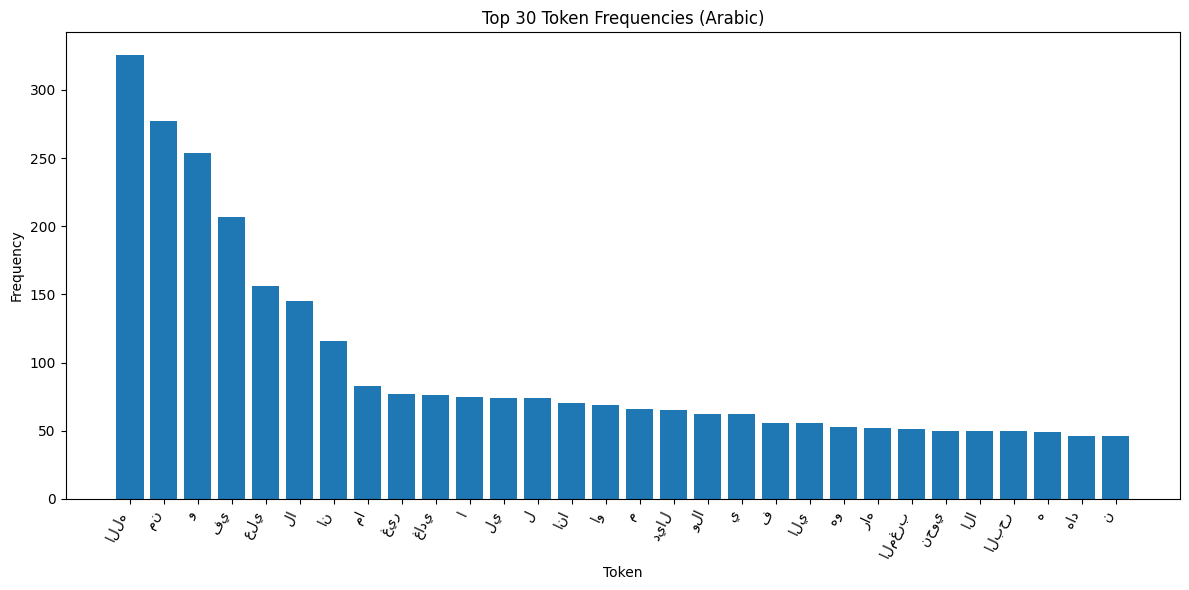

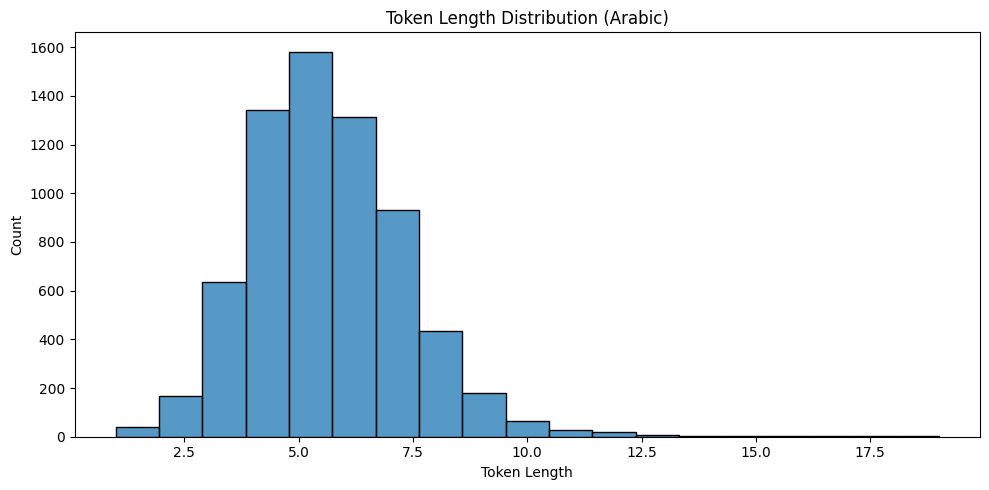


Top 30 tokens (Arabic):
     token  frequency  length  rel_frequency
0     الله        326       4       0.018540
1       من        277       2       0.015753
2        و        254       1       0.014445
3       في        207       2       0.011772
4      علي        156       3       0.008872
5       لا        145       2       0.008246
6       ان        116       2       0.006597
7       ما         83       2       0.004720
8      غير         77       3       0.004379
9     غادي         76       4       0.004322
10       ا         75       1       0.004265
11      لي         74       2       0.004208
12       ل         74       1       0.004208
13     انا         70       3       0.003981
14      او         69       2       0.003924
15       م         66       1       0.003753
16    ديال         65       4       0.003697
17     ولا         62       3       0.003526
18       ي         62       1       0.003526
19       ف         56       1       0.003185
20     الي         56       3 

In [10]:
# Process the corpus (use a sample size for testing)
# Set sample_size=None to process the entire corpus
raw_text_sample, processed_arabic_text, arabic_tokens, stats = preprocess_darija_corpus_to_arabic(
    corpus_dir, 
    sample_size=100000  # Adjust as needed
)

# --- Display Sample Output ---
print("\n" + "="*20 + " Sample of Raw Text " + "="*20)
print(raw_text_sample[:500]) # Show a bit more raw text

print("\n" + "="*20 + " Sample of Processed Arabic Text " + "="*20)
print(processed_arabic_text[:500])

# --- Analyze the Arabic Tokens ---
print("\n" + "="*20 + " Corpus Analysis (Arabic Tokens) " + "="*20)
token_df_arabic = analyze_corpus(arabic_tokens, top_n=30)

# Display top tokens
print("\nTop 30 tokens (Arabic):")
print(token_df_arabic.head(30))

# --- Save the Results ---
# Save the processed Arabic text to a file
output_file_arabic = 'preprocessed_darija_corpus_arabic.txt'
with open(output_file_arabic, 'w', encoding='utf-8') as f:
    f.write(processed_arabic_text)
print(f"\nSaved preprocessed Arabic corpus to {output_file_arabic}")

# Save the token list (one token per line) for word2vec training
tokens_file_arabic = 'darija_tokens_arabic.txt'
with open(tokens_file_arabic, 'w', encoding='utf-8') as f:
    for token in arabic_tokens:
        f.write(token + '\n')
print(f"Saved {len(arabic_tokens)} Arabic tokens to {tokens_file_arabic}")